# Import necessary libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA

# Load data

In [20]:
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

customer_features = customers_df.copy()
trans_agg = transactions_df.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'TotalValue': ['sum', 'mean'],
    'Quantity': ['sum', 'mean']
})
trans_agg.columns = ['transaction_count', 'total_spend', 'avg_transaction_value', 'total_quantity', 'avg_quantity']
trans_agg = trans_agg.reset_index()
customer_features = customer_features.merge(trans_agg, on='CustomerID', how='left')
customer_features = customer_features.fillna(0)

In [21]:
features_for_clustering = ['transaction_count', 'total_spend', 'avg_transaction_value', 'total_quantity', 'avg_quantity']
X = customer_features[features_for_clustering]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create customer features

In [22]:
customer_features = customers_df.copy()
trans_agg = transactions_df.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'TotalValue': ['sum', 'mean'],
    'Quantity': ['sum', 'mean']
})
trans_agg.columns = ['transaction_count', 'total_spend', 'avg_transaction_value', 'total_quantity', 'avg_quantity']
trans_agg = trans_agg.reset_index()
customer_features = customer_features.merge(trans_agg, on='CustomerID', how='left')
customer_features = customer_features.fillna(0)
features_for_clustering = ['transaction_count', 'total_spend', 'avg_transaction_value', 'total_quantity', 'avg_quantity']
X = customer_features[features_for_clustering]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find optimal number of clusters

In [23]:
db_scores = []
silhouette_scores = []
ch_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    db_scores.append(davies_bouldin_score(X_scaled, labels))
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))

optimal_k = K[np.argmin(db_scores)]

# Visualize clustering metrics

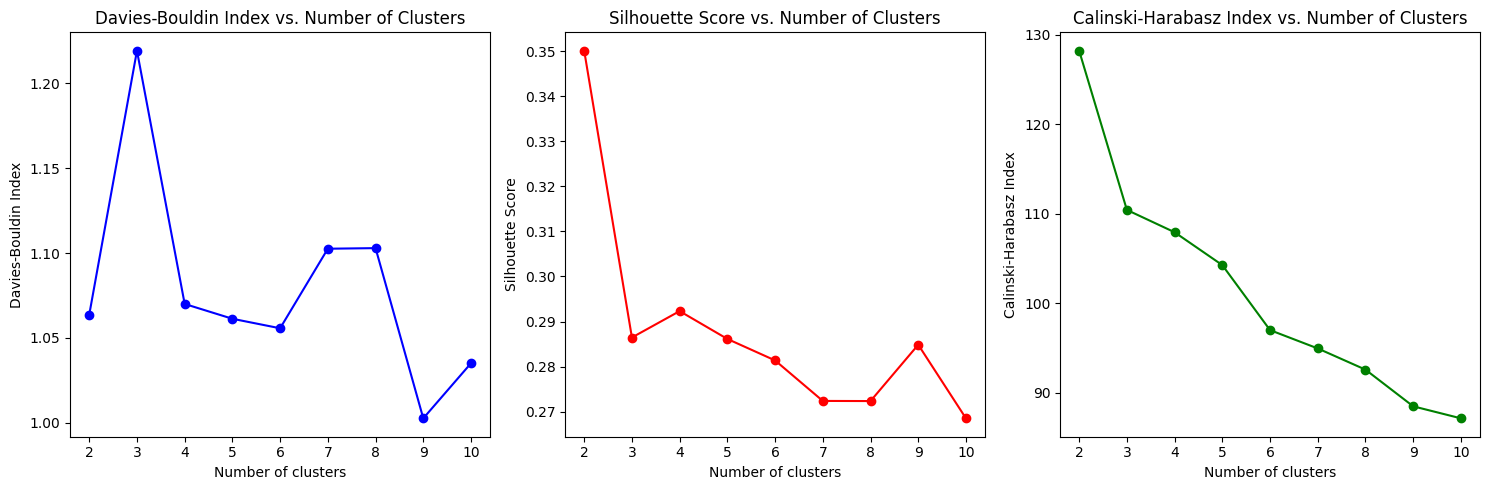

In [24]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(K, db_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs. Number of Clusters')

plt.subplot(132)
plt.plot(K, silhouette_scores, 'ro-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')

plt.subplot(133)
plt.plot(K, ch_scores, 'go-')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index vs. Number of Clusters')

plt.tight_layout()
plt.show()


# Perform final clustering

In [25]:
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_features['Cluster'] = final_kmeans.fit_predict(X_scaled)

final_db_score = davies_bouldin_score(X_scaled, customer_features['Cluster'])
final_silhouette_score = silhouette_score(X_scaled, customer_features['Cluster'])
final_ch_score = calinski_harabasz_score(X_scaled, customer_features['Cluster'])

print(f"Optimal number of clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {final_db_score:.4f}")
print(f"Silhouette Score: {final_silhouette_score:.4f}")
print(f"Calinski-Harabasz Index: {final_ch_score:.4f}")

customer_features.to_csv('John_Joshua_Clustering.csv', index=False)

Optimal number of clusters: 9
Davies-Bouldin Index: 1.0027
Silhouette Score: 0.2849
Calinski-Harabasz Index: 88.5094


# Visualize clusters using PCA

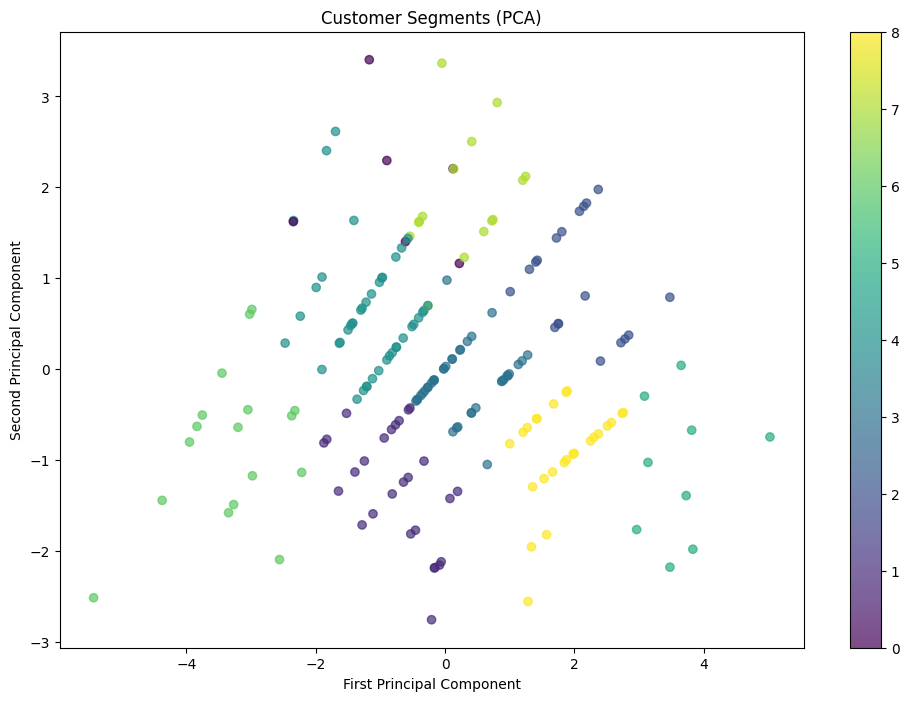

In [26]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=customer_features['Cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title('Customer Segments (PCA)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

# Analyze cluster characteristics

In [27]:
cluster_analysis = customer_features.groupby('Cluster').agg({
    'transaction_count': ['mean', 'std'],
    'total_spend': ['mean', 'std'],
    'avg_transaction_value': ['mean', 'std'],
    'total_quantity': ['mean', 'std'],
    'avg_quantity': ['mean', 'std']
})

print("\nCluster Characteristics:")
print(cluster_analysis)


Cluster Characteristics:
        transaction_count            total_spend               \
                     mean       std         mean          std   
Cluster                                                         
0                2.333333  1.211060  1598.033333   940.917206   
1                6.000000  1.386750  2784.251481   691.230635   
2                5.736842  0.871914  5486.414737   829.801738   
3                5.410256  0.594623  3636.204615   776.884470   
4                3.162791  0.897887  2087.783721   580.061983   
5                9.555556  1.130388  7231.870000  1552.948383   
6                2.058824  1.344925   605.959412   374.559647   
7                3.400000  0.632456  3736.682667   706.609907   
8                7.840000  0.746101  5518.625200   796.439933   

        avg_transaction_value             total_quantity            \
                         mean         std           mean       std   
Cluster                                              

# Visualize cluster characteristics

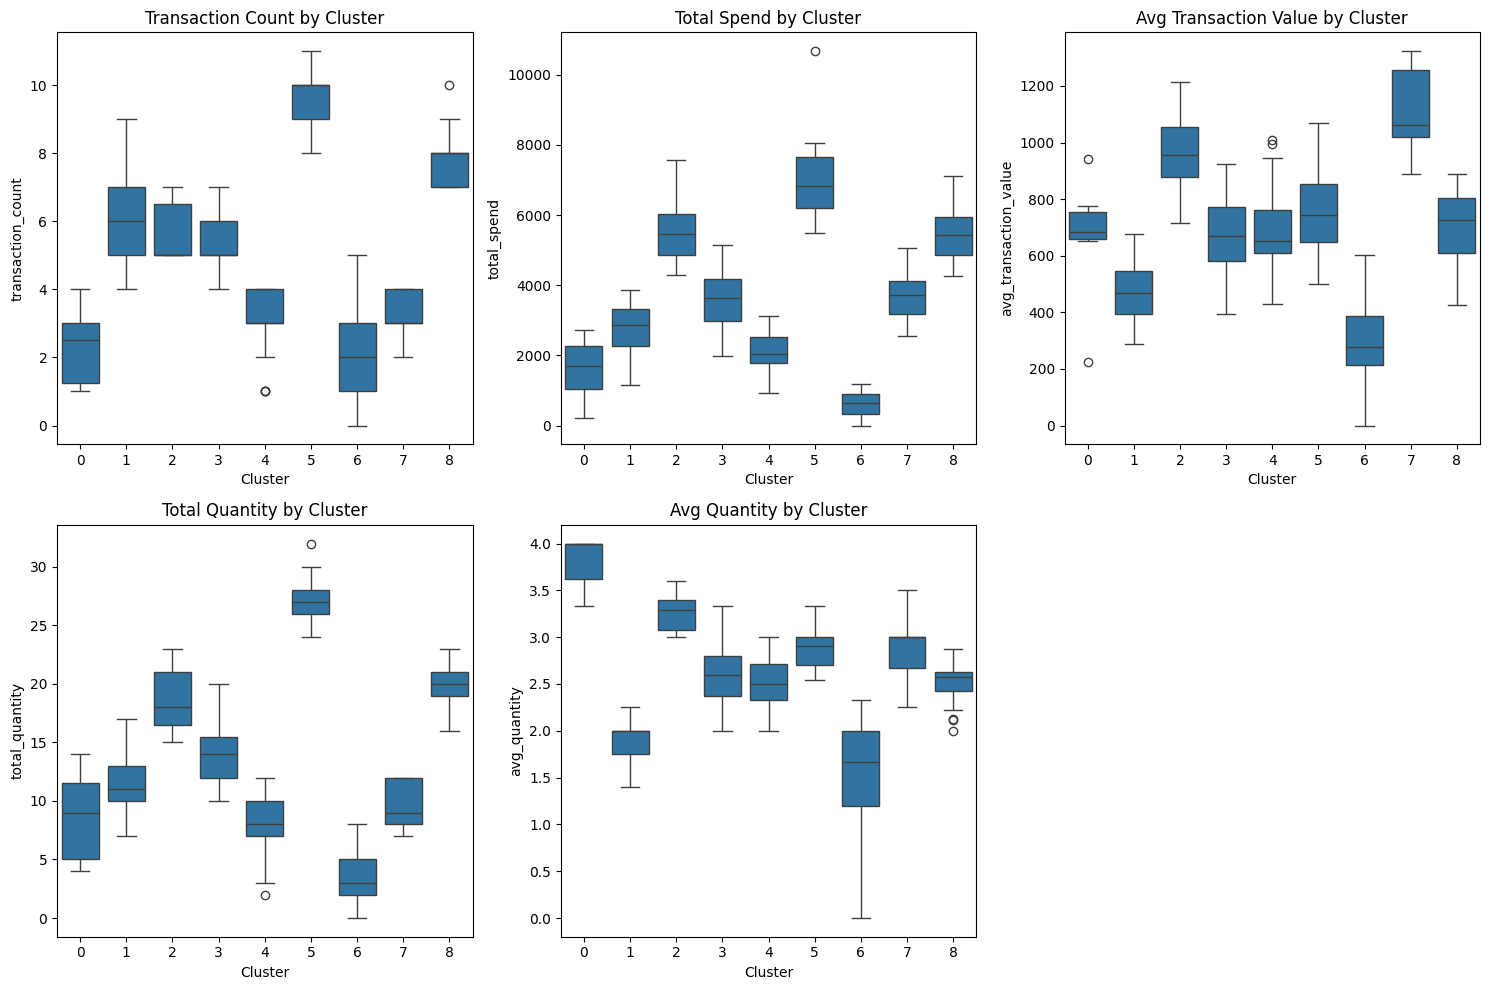

In [28]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_for_clustering):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Cluster', y=feature, data=customer_features)
    plt.title(f'{feature.replace("_", " ").title()} by Cluster')
plt.tight_layout()
plt.show()

# Interpret clusters

In [29]:
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    for feature in features_for_clustering:
        mean = cluster_analysis.loc[cluster, (feature, 'mean')]
        std = cluster_analysis.loc[cluster, (feature, 'std')]
        print(f"  {feature.replace('_', ' ').title()}: {mean:.2f} ± {std:.2f}")


    if cluster_analysis.loc[cluster, ('total_spend', 'mean')] > cluster_analysis['total_spend']['mean'].mean():
        print("  Interpretation: High-value customers")
    elif cluster_analysis.loc[cluster, ('transaction_count', 'mean')] > cluster_analysis['transaction_count']['mean'].mean():
        print("  Interpretation: Frequent shoppers")
    else:
        print("  Interpretation: Average or low-value customers")


Cluster 0:
  Transaction Count: 2.33 ± 1.21
  Total Spend: 1598.03 ± 940.92
  Avg Transaction Value: 660.65 ± 238.66
  Total Quantity: 8.67 ± 4.13
  Avg Quantity: 3.81 ± 0.31
  Interpretation: Average or low-value customers

Cluster 1:
  Transaction Count: 6.00 ± 1.39
  Total Spend: 2784.25 ± 691.23
  Avg Transaction Value: 471.12 ± 104.35
  Total Quantity: 11.22 ± 2.26
  Avg Quantity: 1.89 ± 0.22
  Interpretation: Frequent shoppers

Cluster 2:
  Transaction Count: 5.74 ± 0.87
  Total Spend: 5486.41 ± 829.80
  Avg Transaction Value: 964.90 ± 130.61
  Total Quantity: 18.68 ± 2.81
  Avg Quantity: 3.26 ± 0.21
  Interpretation: High-value customers

Cluster 3:
  Transaction Count: 5.41 ± 0.59
  Total Spend: 3636.20 ± 776.88
  Avg Transaction Value: 671.69 ± 121.40
  Total Quantity: 13.92 ± 2.14
  Avg Quantity: 2.58 ± 0.30
  Interpretation: High-value customers

Cluster 4:
  Transaction Count: 3.16 ± 0.90
  Total Spend: 2087.78 ± 580.06
  Avg Transaction Value: 682.71 ± 141.20
  Total Quan